In [1]:
# parameters
config_dir = "../experiments"
exp_name = "016_norm_v5/base"

In [2]:
%cd /kaggle/working

from pathlib import Path

from hydra import compose, initialize
from omegaconf import OmegaConf

with initialize(
    version_base=None, config_path=f"{config_dir}/{exp_name.split('/')[0]}"
):
    cfg = compose(
        config_name="config.yaml",
        overrides=[f"exp={exp_name.split('/')[-1]}"],
        return_hydra_config=True,
    )
import pickle

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

# 定数定義
output_dir = Path(f"output/experiments/{exp_name}")
gcs_path = f"gs://{cfg.dir.gcs_bucket}/{cfg.dir.gcs_base_dir}/experiments/{exp_name}/"

# カラムの定義
single_targets = [
    "cam_out_NETSW",
    "cam_out_FLWDS",
    "cam_out_PRECSC",
    "cam_out_PRECC",
    "cam_out_SOLS",
    "cam_out_SOLL",
    "cam_out_SOLSD",
    "cam_out_SOLLD",
]
seq_targets = [
    "ptend_t",
    "ptend_q0001",
    "ptend_q0002",
    "ptend_q0003",
    "ptend_u",
    "ptend_v",
]
target_columns = []
for col in seq_targets:
    for i in range(60):
        target_columns.append(f"{col}_{i}")
target_columns.extend(single_targets)


# 結果などの読み込み
r2_score_dict = pickle.load(open(output_dir / "r2_score_dict.pkl", "rb"))
print("read predict")
predict_df = pl.read_parquet(gcs_path + "predict.parquet", retries=5)
print("read label")
label_df = pl.read_parquet(gcs_path + "label.parquet", retries=5)
ss_df = pl.read_csv(
    "input/leap-atmospheric-physics-ai-climsim/sample_submission.csv", n_rows=1
)
weight_array = ss_df.select([x for x in ss_df.columns if x != "sample_id"]).to_numpy()[
    0
]

/kaggle/working
read predict
read label


## 全体概要

In [3]:
print("r2: ", np.mean(list(r2_score_dict.values())))

r2:  -3.1214273949460687e+23


## sequential target

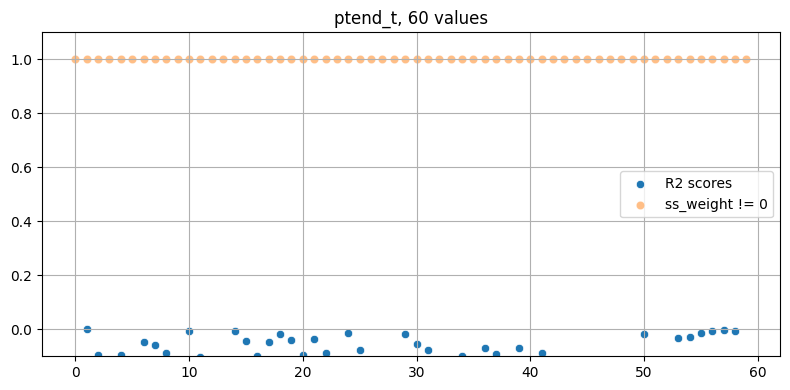

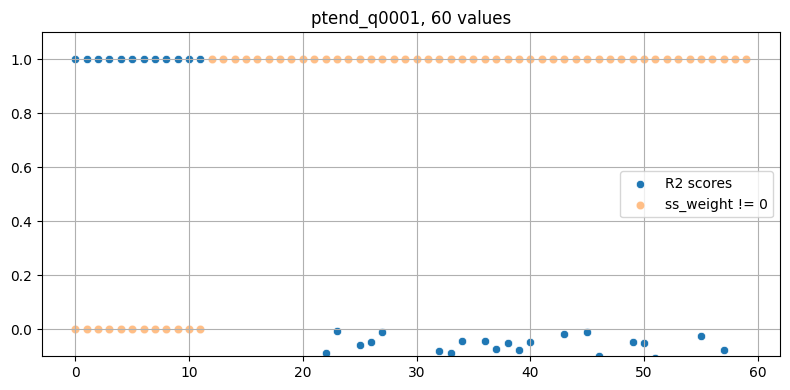

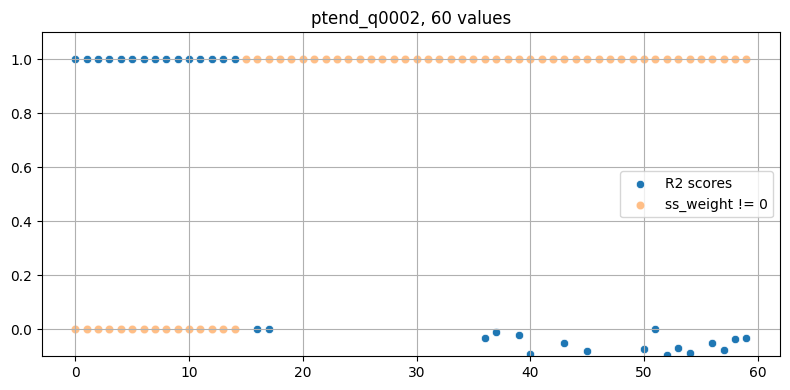

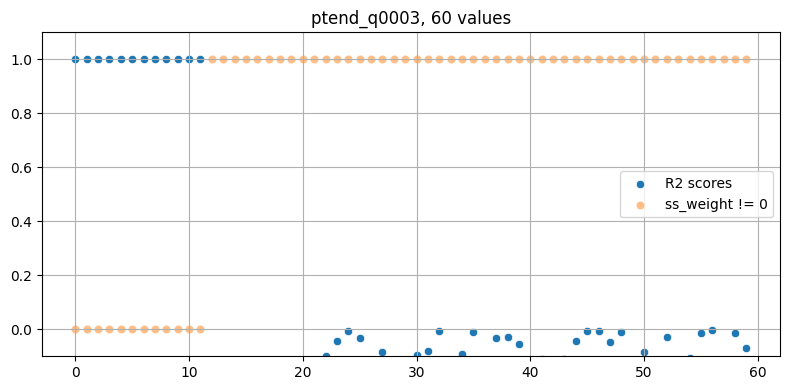

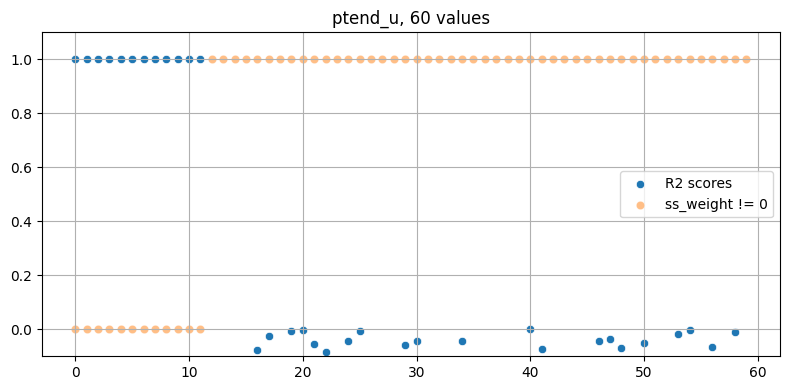

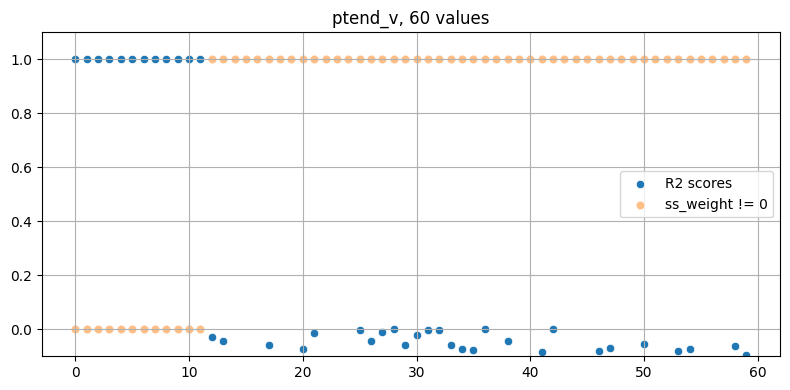

In [4]:
for col in seq_targets:
    fig, ax = plt.subplots(figsize=(8, 4))

    sns.scatterplot(
        x=range(60),
        y=[r2_score_dict[f"{col}_{i}"] for i in range(60)],
        label="R2 scores",
        ax=ax,
    )
    sns.scatterplot(
        x=range(60),
        y=[(ss_df[f"{col}_{i}"].to_numpy()[0] != 0) for i in range(60)],
        alpha=0.5,
        label="ss_weight != 0",
        ax=ax,
    )

    ax.set_title(f"{col}, 60 values")
    ax.grid(True)
    ax.set_ylim(-0.1, 1.1)
    ax.legend()

    plt.tight_layout()
    plt.show()

## single target

cam_out_NETSW : -0.15841711043224405
cam_out_FLWDS : -0.04209240829644978
cam_out_PRECSC : -0.0027535692127909073
cam_out_PRECC : -0.04718778265198509
cam_out_SOLS : -0.18961415563828177
cam_out_SOLL : -0.07873439621917644
cam_out_SOLSD : -0.1920416879549134
cam_out_SOLLD : -0.06974011109510814


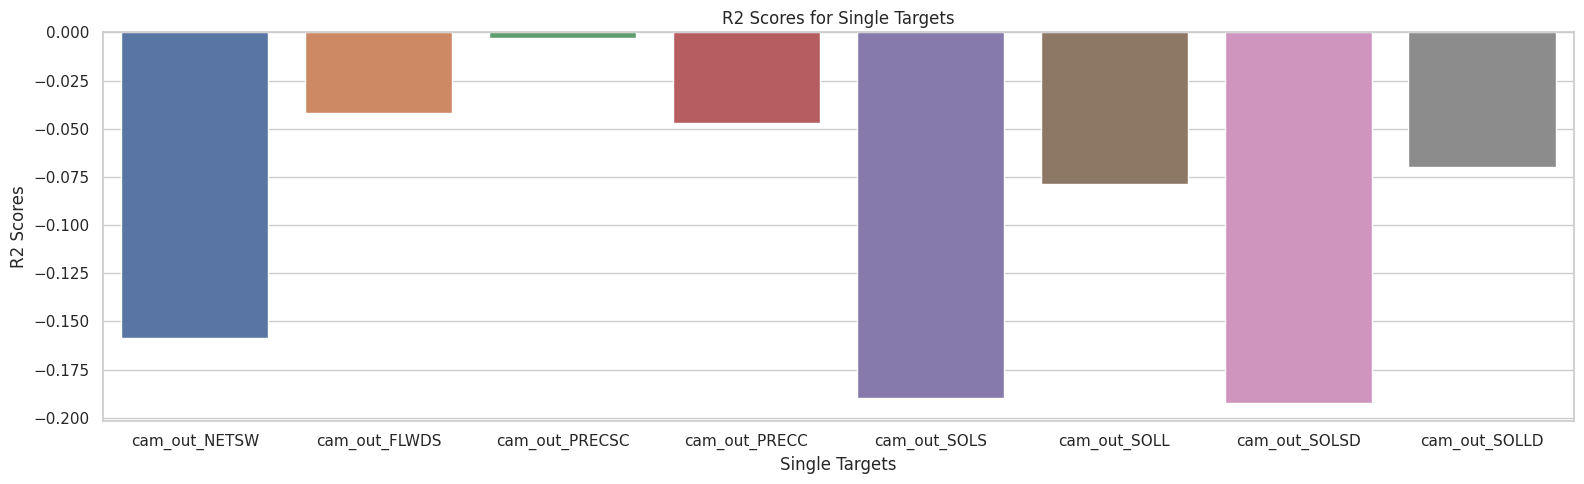

In [5]:
# single scaler target
plt.figure(figsize=(16, 5))
sns.set(style="whitegrid")

sns.barplot(
    x=np.array(single_targets),
    y=np.array([r2_score_dict[col] for col in single_targets]),
)

plt.xlabel("Single Targets")
plt.ylabel("R2 Scores")
plt.title("R2 Scores for Single Targets")

for col in single_targets:
    print(f"{col} : {r2_score_dict[col]}")

plt.tight_layout()
plt.show()

## マイナスが大きいターゲットについて確認

In [6]:
preds = predict_df[:, 1:].to_numpy()
labels = label_df[:, 1:].to_numpy()

scale_dir = ""
y_nanmean = np.load(Path(cfg.exp.scale_dir) / f"y_nanmean_{cfg.exp.norm_name}.npy")
y_rms_sub = np.load(Path(cfg.exp.scale_dir) / f"y_rms_sub_{cfg.exp.norm_name}.npy")
y_lower_bound = np.load(
    Path(cfg.exp.scale_dir) / f"y_lower_bound_{cfg.exp.norm_name}.npy"
)
y_upper_bound = np.load(
    Path(cfg.exp.scale_dir) / f"y_upper_bound_{cfg.exp.norm_name}.npy"
)


for ci, col in enumerate(target_columns):
    r2_score = r2_score_dict[col]
    if r2_score > 0.01:
        continue

    print("【", col, "】")
    print(f"{r2_score=:.5g}")

    mse = (preds[:, ci] - labels[:, ci]) ** 2
    base = (labels[:, ci] - labels[:, ci].mean()) ** 2
    ri = np.nonzero(mse == np.max(mse))[0][0]
    print(f"{ri=}, {ci=}")
    print(f"{preds[ri,ci]=:.5g}, {labels[ri,ci]=:.5g}")
    print(f"{mse[ri]=:.5g}, r2: 1-({mse.mean()=:.5g})/({base.mean()=:.5g})")

    print(
        f"{y_rms_sub[ci]=:.5g}, {y_nanmean[ci]=:.5g}, {y_lower_bound[ci]=:.5g}, {y_upper_bound[ci]=:.5g}"
    )
    print(
        f"{preds[:,ci].mean()=:.5g}, {preds[:,ci].min()=:.5g}, {preds[:,ci].max()=:.5g}"
    )
    print(
        f"{labels[:,ci].mean()=:.5g}, {labels[:,ci].min()=:.5g}, {labels[:,ci].max()=:.5g}"
    )
    print()

【 ptend_t_0 】
r2_score=-0.292
ri=379, ci=0
preds[ri,ci]=-2.4652e-06, labels[ri,ci]=5.9823e-05
mse[ri]=3.8798e-09, r2: 1-(mse.mean()=9.1867e-10)/(base.mean()=7.1104e-10)
y_rms_sub[ci]=3.0425e-05, y_nanmean[ci]=1.0277e-05, y_lower_bound[ci]=-0.0011344, y_upper_bound[ci]=0.0021631
preds[:,ci].mean()=-2.5419e-06, preds[:,ci].min()=-2.6243e-06, preds[:,ci].max()=-2.4408e-06
labels[:,ci].mean()=1.1865e-05, labels[:,ci].min()=-4.3717e-05, labels[:,ci].max()=5.9823e-05

【 ptend_t_1 】
r2_score=-0.00079644
ri=353, ci=1
preds[ri,ci]=-1.0063e-05, labels[ri,ci]=-0.00013155
mse[ri]=1.4759e-08, r2: 1-(mse.mean()=1.8604e-09)/(base.mean()=1.8589e-09)
y_rms_sub[ci]=4.1836e-05, y_nanmean[ci]=-7.0465e-06, y_lower_bound[ci]=-0.0011881, y_upper_bound[ci]=0.0016273
preds[:,ci].mean()=-9.7376e-06, preds[:,ci].min()=-1.013e-05, preds[:,ci].max()=-9.4282e-06
labels[:,ci].mean()=-1.1286e-05, labels[:,ci].min()=-0.00013155, labels[:,ci].max()=7.682e-05

【 ptend_t_2 】
r2_score=-0.096498
ri=721, ci=2
preds[ri,ci]=-

## 値が大きくないやつ

In [7]:
preds = predict_df[:, 1:].to_numpy()
labels = label_df[:, 1:].to_numpy()

scale_dir = ""
y_nanmean = np.load(Path(cfg.exp.scale_dir) / f"y_nanmean_{cfg.exp.norm_name}.npy")
y_rms_sub = np.load(Path(cfg.exp.scale_dir) / f"y_rms_sub_{cfg.exp.norm_name}.npy")
y_lower_bound = np.load(
    Path(cfg.exp.scale_dir) / f"y_lower_bound_{cfg.exp.norm_name}.npy"
)
y_upper_bound = np.load(
    Path(cfg.exp.scale_dir) / f"y_upper_bound_{cfg.exp.norm_name}.npy"
)


for ci, col in enumerate(target_columns):
    r2_score = r2_score_dict[col]
    if r2_score > 0.5:
        continue

    print("【", col, "】")
    print(f"{r2_score=:.5g}")

    mse = (preds[:, ci] - labels[:, ci]) ** 2
    base = (labels[:, ci] - labels[:, ci].mean()) ** 2
    ri = np.nonzero(mse == np.max(mse))[0][0]
    print(f"{ri=}, {ci=}")
    print(f"{preds[ri,ci]=:.5g}, {labels[ri,ci]=:.5g}")
    print(f"{mse[ri]=:.5g}, r2: 1-({mse.mean()=:.5g})/({base.mean()=:.5g})")

    print(
        f"{y_rms_sub[ci]=:.5g}, {y_nanmean[ci]=:.5g}, {y_lower_bound[ci]=:.5g}, {y_upper_bound[ci]=:.5g}"
    )
    print(
        f"{preds[:,ci].mean()=:.5g}, {preds[:,ci].min()=:.5g}, {preds[:,ci].max()=:.5g}"
    )
    print(
        f"{labels[:,ci].mean()=:.5g}, {labels[:,ci].min()=:.5g}, {labels[:,ci].max()=:.5g}"
    )
    print()

【 ptend_t_0 】
r2_score=-0.292
ri=379, ci=0
preds[ri,ci]=-2.4652e-06, labels[ri,ci]=5.9823e-05
mse[ri]=3.8798e-09, r2: 1-(mse.mean()=9.1867e-10)/(base.mean()=7.1104e-10)
y_rms_sub[ci]=3.0425e-05, y_nanmean[ci]=1.0277e-05, y_lower_bound[ci]=-0.0011344, y_upper_bound[ci]=0.0021631
preds[:,ci].mean()=-2.5419e-06, preds[:,ci].min()=-2.6243e-06, preds[:,ci].max()=-2.4408e-06
labels[:,ci].mean()=1.1865e-05, labels[:,ci].min()=-4.3717e-05, labels[:,ci].max()=5.9823e-05

【 ptend_t_1 】
r2_score=-0.00079644
ri=353, ci=1
preds[ri,ci]=-1.0063e-05, labels[ri,ci]=-0.00013155
mse[ri]=1.4759e-08, r2: 1-(mse.mean()=1.8604e-09)/(base.mean()=1.8589e-09)
y_rms_sub[ci]=4.1836e-05, y_nanmean[ci]=-7.0465e-06, y_lower_bound[ci]=-0.0011881, y_upper_bound[ci]=0.0016273
preds[:,ci].mean()=-9.7376e-06, preds[:,ci].min()=-1.013e-05, preds[:,ci].max()=-9.4282e-06
labels[:,ci].mean()=-1.1286e-05, labels[:,ci].min()=-0.00013155, labels[:,ci].max()=7.682e-05

【 ptend_t_2 】
r2_score=-0.096498
ri=721, ci=2
preds[ri,ci]=-